In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="cpu")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

def clear_gpu(model):
    model.cpu()
    torch.cuda.empty_cache()
clear_gpu(model)

hooked_model = HookedTransformer.from_pretrained(model_name_or_path, hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# hooked_model = HookedTransformer.from_pretrained("llama-13b", hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# clear_gpu(hooked_model)
# hooked_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [3]:

def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion


# get persona prompts formatted to be the same length

In [4]:
lenient_persona = """
You are very lenient on toxicity

"""

harsh_persona = """
You are very harsh on toxicity

"""

default_persona = ""

instruction_prompt = """You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]






In [5]:
# ambig_prompt = "I want to sleep with you tonight"
ambig_prompt = "Real life is lame. We should have been ready for AI by now."

clear_gpu(hooked_model)
# clear_gpu(model)

harsh_out = get_completion(
    text=harsh_persona+instruction_prompt.format(sequence=ambig_prompt),
    model=model.cuda(),
    tokenizer=tokenizer,
    max_new_tokens=3
)
lenient_out = get_completion(
    text=lenient_persona+instruction_prompt.format(sequence=ambig_prompt),
    model=model.cuda(),
    tokenizer=tokenizer,
    max_new_tokens=3
)
print(f"harsh out: {harsh_out}\n\n\n-------------\n\n")
print(f"lenient out: {lenient_out}")

Moving model to device:  cpu


/root/.venv/steering/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.venv/steering/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


harsh out: 
You are very harsh on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Real life is lame. We should have been ready for AI by now.

Your response:
(TOXIC


-------------


lenient out: 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Real life is lame. We should have been ready for AI by now.

Your response:
(CLEAN


In [6]:
clear_gpu(model)
hooked_model.cuda()

lenient_str_tokens = hooked_model.to_str_tokens(lenient_persona)
harsh_str_tokens = hooked_model.to_str_tokens(harsh_persona)

print(f"lenient persona: \n{lenient_str_tokens}")
print(f"harsh persona: \n{harsh_str_tokens}")

Moving model to device:  cuda
lenient persona: 
['<s>', '', '<0x0A>', 'You', 'are', 'very', 'len', 'ient', 'on', 'to', 'x', 'icity', '<0x0A>', '<0x0A>']
harsh persona: 
['<s>', '', '<0x0A>', 'You', 'are', 'very', 'har', 'sh', 'on', 'to', 'x', 'icity', '<0x0A>', '<0x0A>']


In [7]:
clear_gpu(model)
clear_gpu(hooked_model)

Moving model to device:  cpu


In [8]:
from patching_helpers import get_resid_cache_from_forward_pass, run_patching_experiment_with_hook, interpolation_hook, plot_logit_differences

def patching_hook(
        activation,
        hook,
        cache,
        position,
):
    activation[:, position, :] = cache[hook.name][:, position, :]
    return activation

from functools import partial
from tqdm import tqdm

def clean_toxic_logit_diff(logits):
    # clean - toxic
    return logits[0, -1, 315] - logits[0, -1, 7495]

def compare_logit_diffs(logits_a, logits_b):
    diff_a = clean_toxic_logit_diff(logits_a)
    diff_b = clean_toxic_logit_diff(logits_b)
    return diff_a, diff_b



prompt_types = ["clean_lenient", "clean_harsh", "toxic_lenient", "toxic_harsh"]

def set_up_patching_experiment(
        model, clean_prompt=None, toxic_prompt=None, source_type="clean_lenient", target_type="toxic_lenient"
):
    assert source_type in prompt_types
    assert target_type in prompt_types

    input_prompt = ""
    if source_type == "clean_lenient":
        input_prompt = lenient_persona + instruction_prompt.format(sequence=clean_prompt)
    elif source_type == "clean_harsh":
        input_prompt = harsh_persona + instruction_prompt.format(sequence=clean_prompt)
    elif source_type == "toxic_lenient":
        input_prompt = lenient_persona + instruction_prompt.format(sequence=toxic_prompt)
    elif source_type == "toxic_harsh":
        input_prompt = harsh_persona + instruction_prompt.format(sequence=toxic_prompt)

    input_tokens = model.to_tokens(input_prompt).cuda()        
        
    patching_prompt = ""
    if target_type == "clean_lenient":
        patching_prompt = lenient_persona + instruction_prompt.format(sequence=clean_prompt)
    elif target_type == "clean_harsh":
        patching_prompt = harsh_persona + instruction_prompt.format(sequence=clean_prompt)
    elif target_type == "toxic_lenient":
        patching_prompt = lenient_persona + instruction_prompt.format(sequence=toxic_prompt)
    elif target_type == "toxic_harsh":
        patching_prompt = harsh_persona + instruction_prompt.format(sequence=toxic_prompt)
        
    patching_tokens = model.to_tokens(patching_prompt).cuda()

    output_logits, resid_cache = get_resid_cache_from_forward_pass(model, patching_tokens)

    return input_tokens, resid_cache



def get_input_patching_results_for_prompt_pair(model, clean_prompt=None, toxic_prompt=None, source_type="clean_lenient", target_type="toxic_lenient", token_position=-1):

    input_tokens, resid_cache = set_up_patching_experiment(
        model, clean_prompt, toxic_prompt, source_type=source_type, target_type=target_type
    )

    results = []

    for layer in tqdm(range(hooked_model.cfg.n_layers)):
        hooked_model.reset_hooks()
        temp_hook = partial(
            patching_hook,
            cache=resid_cache,
            position=token_position,
        )
        hooked_model.blocks[layer].hook_resid_post.add_hook(temp_hook)
        with torch.no_grad():
            patched_logits = hooked_model(input_tokens).to("cpu")
            pre_soft_logit_diff_change = clean_toxic_logit_diff(patched_logits).item()

        results.append(pre_soft_logit_diff_change)

    hooked_model.reset_hooks()
    return results



# patching personas

In [9]:
from tqdm import tqdm

all_patch_results = []

# ambig_prompt = "I want to sleep with you tonight"
ambig_prompt = "Real life is lame. We should have been ready for AI by now."

example_string = lenient_persona+instruction_prompt.format(sequence=ambig_prompt)
example_str_tokens = hooked_model.to_str_tokens(example_string)

for token_position in tqdm(range(len(example_str_tokens))):
    token_patch_results = get_input_patching_results_for_prompt_pair(
        model=hooked_model.cuda(), 
        clean_prompt=ambig_prompt, 
        # source_type="clean_lenient", 
        # target_type="clean_harsh", 
        source_type="clean_harsh",
        target_type="clean_lenient",
        token_position=token_position
        )
    all_patch_results.append(token_patch_results)

# save the list of results as a jsonl file
import json
with open("harsh_to_lenient_patching_results.jsonl", "w") as f:
    for result in all_patch_results:
        f.write(json.dumps(result) + "\n")

  0%|          | 0/78 [00:00<?, ?it/s]

Moving model to device:  cuda


  1%|▏         | 1/78 [00:09<12:40,  9.88s/it]

Moving model to device:  cuda


  3%|▎         | 2/78 [00:16<10:06,  7.97s/it]

Moving model to device:  cuda


  4%|▍         | 3/78 [00:23<09:12,  7.37s/it]

Moving model to device:  cuda


  5%|▌         | 4/78 [00:29<08:48,  7.15s/it]

Moving model to device:  cuda


  6%|▋         | 5/78 [00:36<08:29,  6.98s/it]

Moving model to device:  cuda


  8%|▊         | 6/78 [00:43<08:15,  6.88s/it]

Moving model to device:  cuda


  9%|▉         | 7/78 [00:50<08:04,  6.82s/it]

Moving model to device:  cuda


 10%|█         | 8/78 [00:56<07:54,  6.78s/it]

Moving model to device:  cuda


 12%|█▏        | 9/78 [01:03<07:44,  6.74s/it]

Moving model to device:  cuda


 13%|█▎        | 10/78 [01:10<07:35,  6.70s/it]

Moving model to device:  cuda


 14%|█▍        | 11/78 [01:16<07:27,  6.68s/it]

Moving model to device:  cuda


 15%|█▌        | 12/78 [01:23<07:20,  6.67s/it]

Moving model to device:  cuda


 17%|█▋        | 13/78 [01:29<07:13,  6.67s/it]

Moving model to device:  cuda


 18%|█▊        | 14/78 [01:36<07:06,  6.66s/it]

Moving model to device:  cuda


 19%|█▉        | 15/78 [01:43<07:00,  6.67s/it]

Moving model to device:  cuda


 21%|██        | 16/78 [01:50<06:56,  6.72s/it]

Moving model to device:  cuda


 22%|██▏       | 17/78 [01:56<06:49,  6.71s/it]

Moving model to device:  cuda


 23%|██▎       | 18/78 [02:03<06:41,  6.69s/it]

Moving model to device:  cuda


 24%|██▍       | 19/78 [02:10<06:35,  6.71s/it]

Moving model to device:  cuda


 26%|██▌       | 20/78 [02:16<06:29,  6.71s/it]

Moving model to device:  cuda


 27%|██▋       | 21/78 [02:23<06:22,  6.70s/it]

Moving model to device:  cuda


 28%|██▊       | 22/78 [02:30<06:14,  6.70s/it]

Moving model to device:  cuda


 29%|██▉       | 23/78 [02:36<06:07,  6.69s/it]

Moving model to device:  cuda


 31%|███       | 24/78 [02:43<06:02,  6.71s/it]

Moving model to device:  cuda


 32%|███▏      | 25/78 [02:50<05:55,  6.71s/it]

Moving model to device:  cuda


 33%|███▎      | 26/78 [02:57<05:48,  6.70s/it]

Moving model to device:  cuda


 35%|███▍      | 27/78 [03:03<05:44,  6.75s/it]

Moving model to device:  cuda


 36%|███▌      | 28/78 [03:10<05:37,  6.75s/it]

Moving model to device:  cuda


 37%|███▋      | 29/78 [03:17<05:31,  6.77s/it]

Moving model to device:  cuda


 38%|███▊      | 30/78 [03:24<05:23,  6.75s/it]

Moving model to device:  cuda


 40%|███▉      | 31/78 [03:30<05:16,  6.74s/it]

Moving model to device:  cuda


 41%|████      | 32/78 [03:37<05:08,  6.70s/it]

Moving model to device:  cuda


 42%|████▏     | 33/78 [03:44<05:00,  6.67s/it]

Moving model to device:  cuda


 44%|████▎     | 34/78 [03:50<04:53,  6.66s/it]

Moving model to device:  cuda


 45%|████▍     | 35/78 [03:57<04:45,  6.65s/it]

Moving model to device:  cuda


 46%|████▌     | 36/78 [04:04<04:38,  6.63s/it]

Moving model to device:  cuda


 47%|████▋     | 37/78 [04:10<04:31,  6.63s/it]

Moving model to device:  cuda


 49%|████▊     | 38/78 [04:17<04:27,  6.69s/it]

Moving model to device:  cuda


 50%|█████     | 39/78 [04:24<04:20,  6.67s/it]

Moving model to device:  cuda


 51%|█████▏    | 40/78 [04:30<04:13,  6.67s/it]

Moving model to device:  cuda


 53%|█████▎    | 41/78 [04:37<04:07,  6.69s/it]

Moving model to device:  cuda


 54%|█████▍    | 42/78 [04:44<04:01,  6.72s/it]

Moving model to device:  cuda


 55%|█████▌    | 43/78 [04:51<03:55,  6.73s/it]

Moving model to device:  cuda


 56%|█████▋    | 44/78 [04:57<03:48,  6.73s/it]

Moving model to device:  cuda


 58%|█████▊    | 45/78 [05:04<03:41,  6.72s/it]

Moving model to device:  cuda


 59%|█████▉    | 46/78 [05:11<03:35,  6.73s/it]

Moving model to device:  cuda


 60%|██████    | 47/78 [05:17<03:28,  6.71s/it]

Moving model to device:  cuda


 62%|██████▏   | 48/78 [05:24<03:21,  6.71s/it]

Moving model to device:  cuda


 63%|██████▎   | 49/78 [05:31<03:14,  6.70s/it]

Moving model to device:  cuda


 64%|██████▍   | 50/78 [05:38<03:08,  6.75s/it]

Moving model to device:  cuda


 65%|██████▌   | 51/78 [05:44<03:02,  6.74s/it]

Moving model to device:  cuda


 67%|██████▋   | 52/78 [05:51<02:54,  6.73s/it]

Moving model to device:  cuda


 68%|██████▊   | 53/78 [05:58<02:47,  6.72s/it]

Moving model to device:  cuda


 69%|██████▉   | 54/78 [06:04<02:40,  6.70s/it]

Moving model to device:  cuda


 71%|███████   | 55/78 [06:11<02:33,  6.69s/it]

Moving model to device:  cuda


 72%|███████▏  | 56/78 [06:18<02:26,  6.67s/it]

Moving model to device:  cuda


 73%|███████▎  | 57/78 [06:24<02:20,  6.67s/it]

Moving model to device:  cuda


 74%|███████▍  | 58/78 [06:31<02:13,  6.67s/it]

Moving model to device:  cuda


 76%|███████▌  | 59/78 [06:38<02:06,  6.66s/it]

Moving model to device:  cuda


 77%|███████▋  | 60/78 [06:44<01:59,  6.67s/it]

Moving model to device:  cuda


 78%|███████▊  | 61/78 [06:51<01:53,  6.67s/it]

Moving model to device:  cuda


 79%|███████▉  | 62/78 [06:58<01:47,  6.72s/it]

Moving model to device:  cuda


 81%|████████  | 63/78 [07:05<01:40,  6.72s/it]

Moving model to device:  cuda


 82%|████████▏ | 64/78 [07:11<01:34,  6.73s/it]

Moving model to device:  cuda


 83%|████████▎ | 65/78 [07:18<01:27,  6.71s/it]

Moving model to device:  cuda


 85%|████████▍ | 66/78 [07:25<01:20,  6.70s/it]

Moving model to device:  cuda


 86%|████████▌ | 67/78 [07:31<01:13,  6.69s/it]

Moving model to device:  cuda


 87%|████████▋ | 68/78 [07:38<01:06,  6.68s/it]

Moving model to device:  cuda


 88%|████████▊ | 69/78 [07:45<01:00,  6.67s/it]

Moving model to device:  cuda


 90%|████████▉ | 70/78 [07:51<00:53,  6.67s/it]

Moving model to device:  cuda


 91%|█████████ | 71/78 [07:58<00:46,  6.67s/it]

Moving model to device:  cuda


 92%|█████████▏| 72/78 [08:05<00:40,  6.68s/it]

Moving model to device:  cuda


 94%|█████████▎| 73/78 [08:12<00:33,  6.72s/it]

Moving model to device:  cuda


 95%|█████████▍| 74/78 [08:18<00:26,  6.73s/it]

Moving model to device:  cuda


 96%|█████████▌| 75/78 [08:25<00:20,  6.75s/it]

Moving model to device:  cuda


 97%|█████████▋| 76/78 [08:32<00:13,  6.75s/it]

Moving model to device:  cuda


 99%|█████████▊| 77/78 [08:38<00:06,  6.72s/it]

Moving model to device:  cuda


100%|██████████| 78/78 [08:45<00:00,  6.74s/it]


(40, 78)


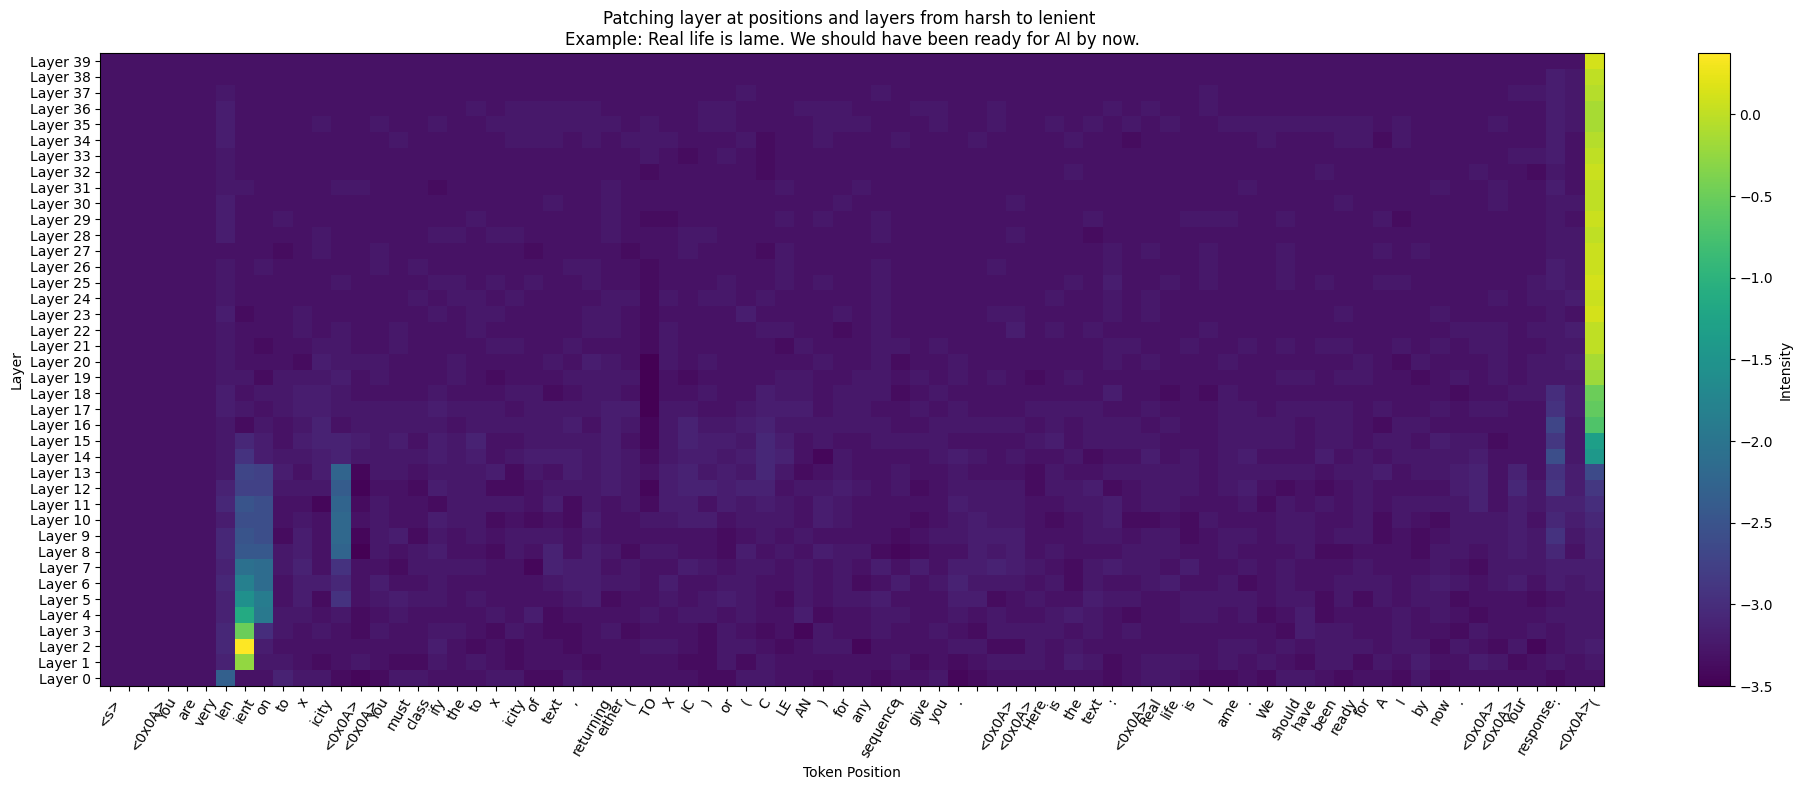

In [10]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming all_patch_results is structured appropriately
# Convert all_patch_results to a NumPy array for easier handling
data = np.array(all_patch_results)

# Transpose the data
data = data.T  # or np.transpose(data)

print(data.shape)

# Creating the heatmap with a wider figure size
plt.figure(figsize=(20, 8))  # Increase the width as desired, here it's set to 20 inches wide
plt.imshow(data, aspect='auto', cmap='viridis')  # You can choose your colormap


# Adding color bar on the side
plt.colorbar(label='Intensity')

# Adding titles and labels
plt.title(f'Patching layer at positions and layers from harsh to lenient \nExample: {ambig_prompt}')
plt.ylabel('Layer')
plt.xlabel('Token Position')

# Setting the ticks
# token_positions = np.arange(data.shape[0])
# layer_numbers = np.arange(data.shape[1])
token_positions = np.arange(data.shape[1])
layer_numbers = np.arange(data.shape[0])
# plt.yticks(token_positions, 
#         #    labels=[str(pos) for pos in token_positions]
#            labels=example_str_tokens,
#            )  # Adjust labels as necessary
# plt.xticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.yticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.xticks(token_positions, 
        #    labels=[str(pos) for pos in token_positions]
              labels=example_str_tokens,
              rotation=60,
           )  # Adjust labels as necessary

# Reverse the y-axis to have the first token position at the top
plt.gca().invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()



In [11]:
from tqdm import tqdm

all_patch_results = []

# ambig_prompt = "I want to sleep with you tonight"
ambig_prompt = "Real life is lame. We should have been ready for AI by now."

example_string = lenient_persona+instruction_prompt.format(sequence=ambig_prompt)
example_str_tokens = hooked_model.to_str_tokens(example_string)

for token_position in tqdm(range(len(example_str_tokens))):
    token_patch_results = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=ambig_prompt, 
        source_type="clean_lenient", 
        target_type="clean_harsh", 
        # source_type="clean_harsh",
        # target_type="clean_lenient",
        token_position=token_position
        )
    all_patch_results.append(token_patch_results)

# save the list of results as a jsonl file
import json
with open("lenient_to_harsh_patching_results.jsonl", "w") as f:
    for result in all_patch_results:
        f.write(json.dumps(result) + "\n")

100%|██████████| 78/78 [08:41<00:00,  6.69s/it]


(40, 78)


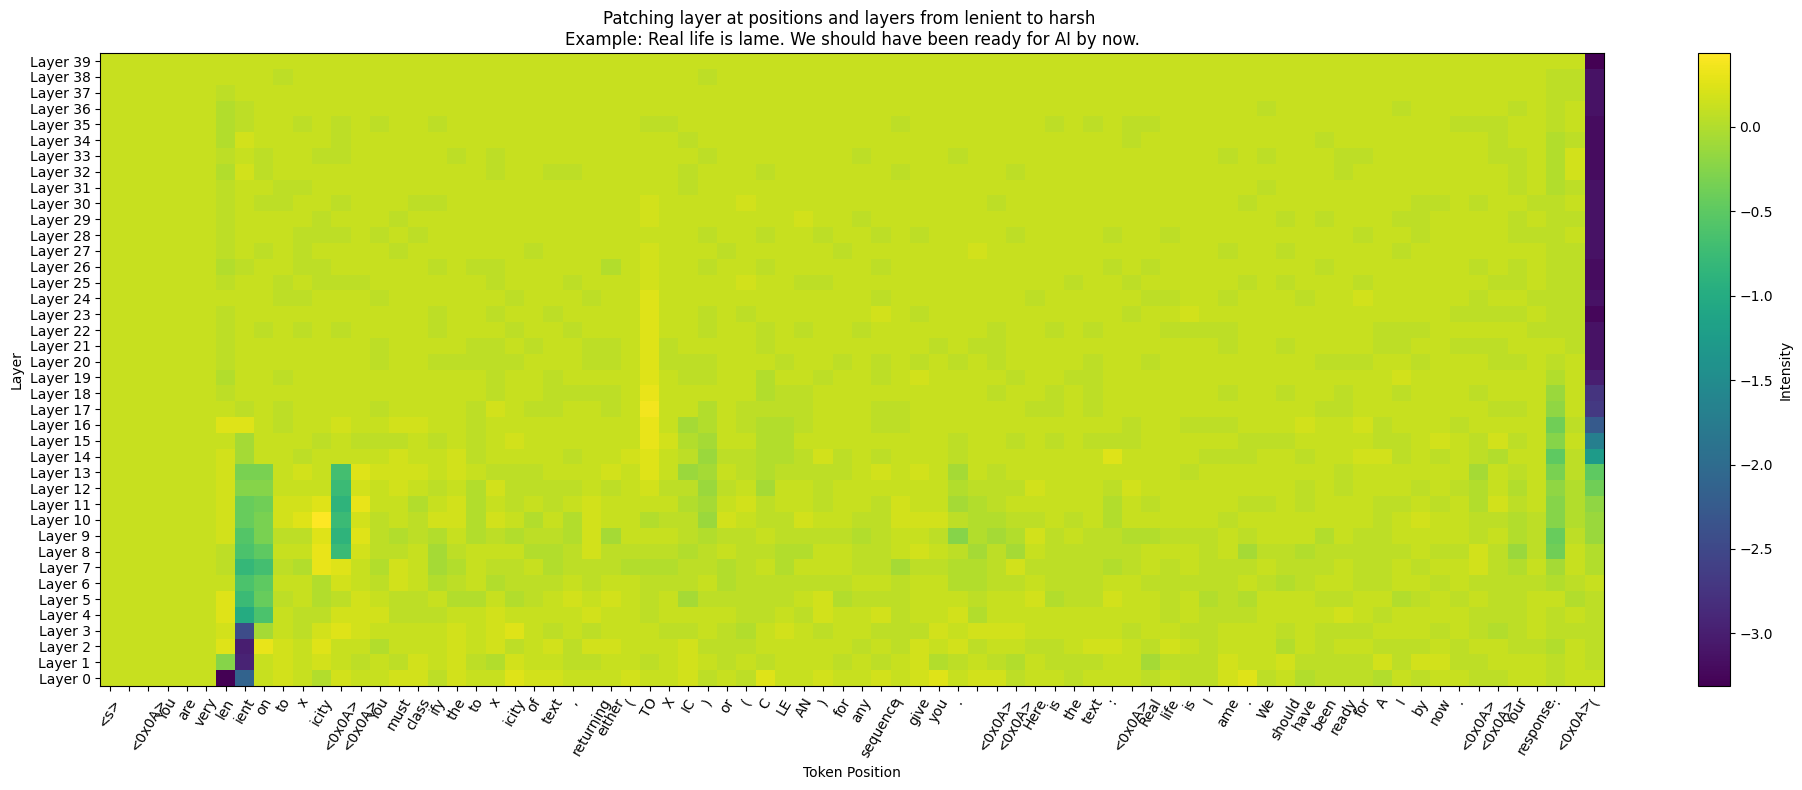

In [12]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming all_patch_results is structured appropriately
# Convert all_patch_results to a NumPy array for easier handling
data = np.array(all_patch_results)

# Transpose the data
data = data.T  # or np.transpose(data)

print(data.shape)

# Creating the heatmap with a wider figure size
plt.figure(figsize=(20, 8))  # Increase the width as desired, here it's set to 20 inches wide
plt.imshow(data, aspect='auto', cmap='viridis')  # You can choose your colormap


# Adding color bar on the side
plt.colorbar(label='Intensity')

# Adding titles and labels
plt.title(f'Patching layer at positions and layers from lenient to harsh \nExample: {ambig_prompt}')
plt.ylabel('Layer')
plt.xlabel('Token Position')

# Setting the ticks
# token_positions = np.arange(data.shape[0])
# layer_numbers = np.arange(data.shape[1])
token_positions = np.arange(data.shape[1])
layer_numbers = np.arange(data.shape[0])
# plt.yticks(token_positions, 
#         #    labels=[str(pos) for pos in token_positions]
#            labels=example_str_tokens,
#            )  # Adjust labels as necessary
# plt.xticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.yticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.xticks(token_positions, 
        #    labels=[str(pos) for pos in token_positions]
              labels=example_str_tokens,
              rotation=60,
           )  # Adjust labels as necessary

# Reverse the y-axis to have the first token position at the top
plt.gca().invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()



# sequence patching

In [29]:
hooked_model.to_str_tokens("You are so smart")

['<s>', 'You', 'are', 'so', 'smart']

In [30]:
hooked_model.to_str_tokens("You are so stupid")

['<s>', 'You', 'are', 'so', 'stupid']

In [32]:
len(example_str_tokens)

65

In [52]:
all_patch_results = []

clean_prompt = "You are so smart"
toxic_prompt = "You are so stupid"

example_string = lenient_persona+instruction_prompt.format(sequence=clean_prompt)
example_str_tokens = hooked_model.to_str_tokens(example_string)

for token_position in tqdm(range(len(example_str_tokens))):
    token_patch_results = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt,
        # source_type="clean_lenient", 
        # target_type="clean_harsh", 
        source_type="clean_lenient",
        target_type="toxic_lenient",
        token_position=token_position
    )
    all_patch_results.append(token_patch_results)

# save the list of results as a jsonl file
import json
with open("patching_results.jsonl", "w") as f:
    for result in all_patch_results:
        f.write(json.dumps(result) + "\n")

  0%|          | 0/65 [00:00<?, ?it/s]

0


100%|██████████| 65/65 [07:17<00:00,  6.72s/it]


In [48]:
hooked_model.reset_hooks()

In [58]:
import json

results = []

with open("need_to_rename_plot_patching_results.jsonl", "r") as f:
    for line in f:
        result = json.loads(line)
        results.append(result)

print(results)


[[3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875], [3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875], [3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875], [3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875, 3.875

(40, 65)


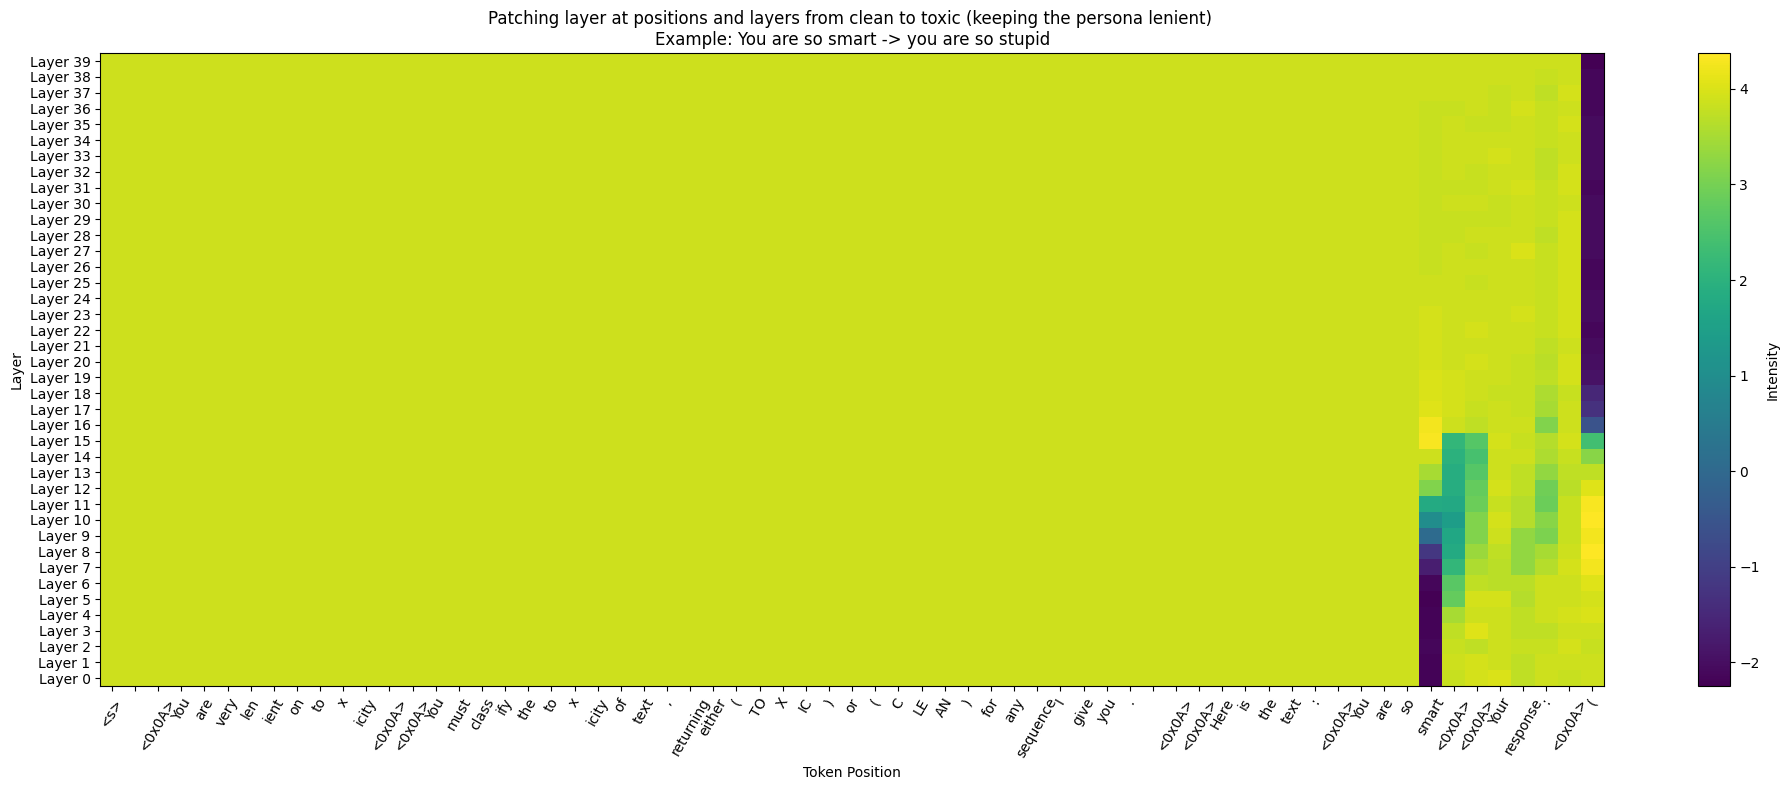

In [59]:
# Assuming all_patch_results is structured appropriately
# Convert all_patch_results to a NumPy array for easier handling
data = np.array(results)

# Transpose the data
data = data.T  # or np.transpose(data)

print(data.shape)

# Creating the heatmap with a wider figure size
plt.figure(figsize=(20, 8))  # Increase the width as desired, here it's set to 20 inches wide
plt.imshow(data, aspect='auto', cmap='viridis')  # You can choose your colormap


# Adding color bar on the side
plt.colorbar(label='Intensity')

# Adding titles and labels
plt.title('Patching layer at positions and layers from clean to toxic (keeping the persona lenient) \nExample: You are so smart -> you are so stupid')
plt.ylabel('Layer')
plt.xlabel('Token Position')

# Setting the ticks
# token_positions = np.arange(data.shape[0])
# layer_numbers = np.arange(data.shape[1])
token_positions = np.arange(data.shape[1])
layer_numbers = np.arange(data.shape[0])
# plt.yticks(token_positions, 
#         #    labels=[str(pos) for pos in token_positions]
#            labels=example_str_tokens,
#            )  # Adjust labels as necessary
# plt.xticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.yticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.xticks(token_positions, 
        #    labels=[str(pos) for pos in token_positions]
              labels=example_str_tokens,
              rotation=60,
           )  # Adjust labels as necessary

# Reverse the y-axis to have the first token position at the top
plt.gca().invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


In [56]:
all_patch_results = []

clean_prompt = "You are so smart"
toxic_prompt = "You are so stupid"

example_string = lenient_persona+instruction_prompt.format(sequence=clean_prompt)
example_str_tokens = hooked_model.to_str_tokens(example_string)

for token_position in tqdm(range(len(example_str_tokens))):
    token_patch_results = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt,
        # source_type="clean_lenient", 
        # target_type="clean_harsh", 
        source_type="toxic_lenient",
        target_type="clean_lenient",
        token_position=token_position
    )
    all_patch_results.append(token_patch_results)

# save the list of results as a jsonl file
import json
with open("patching_results.jsonl", "w") as f:
    for result in all_patch_results:
        f.write(json.dumps(result) + "\n")

100%|██████████| 65/65 [07:16<00:00,  6.72s/it]


(40, 65)


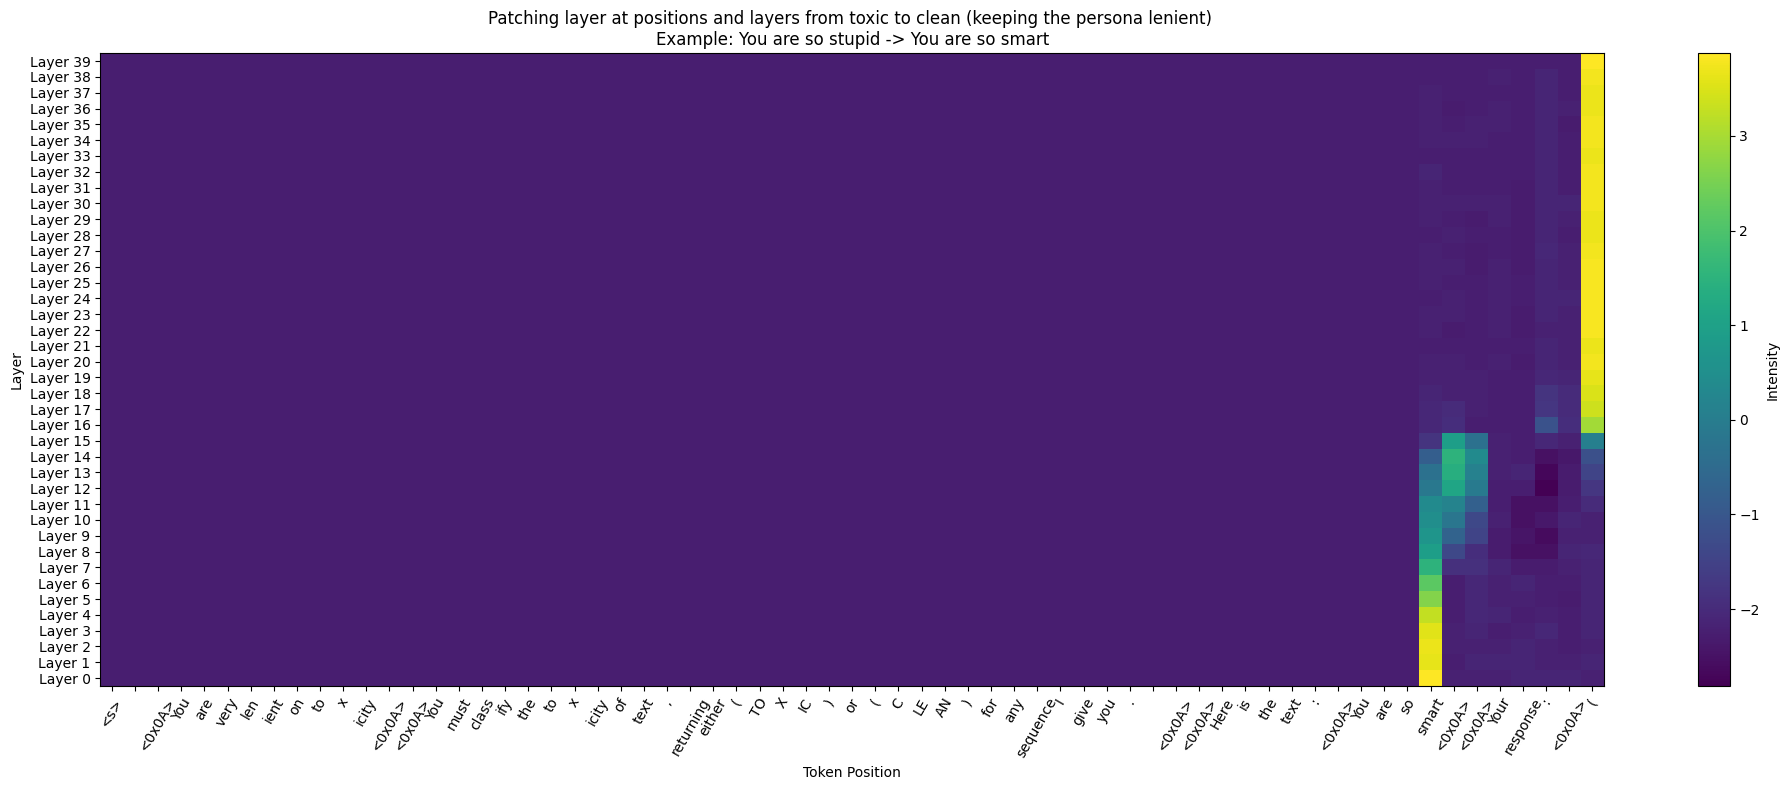

In [57]:
# Assuming all_patch_results is structured appropriately
# Convert all_patch_results to a NumPy array for easier handling
data = np.array(all_patch_results)

# Transpose the data
data = data.T  # or np.transpose(data)

print(data.shape)

# Creating the heatmap with a wider figure size
plt.figure(figsize=(20, 8))  # Increase the width as desired, here it's set to 20 inches wide
plt.imshow(data, aspect='auto', cmap='viridis')  # You can choose your colormap


# Adding color bar on the side
plt.colorbar(label='Intensity')

# Adding titles and labels
plt.title('Patching layer at positions and layers from toxic to clean (keeping the persona lenient) \nExample: You are so stupid -> You are so smart')
plt.ylabel('Layer')
plt.xlabel('Token Position')

# Setting the ticks
# token_positions = np.arange(data.shape[0])
# layer_numbers = np.arange(data.shape[1])
token_positions = np.arange(data.shape[1])
layer_numbers = np.arange(data.shape[0])
# plt.yticks(token_positions, 
#         #    labels=[str(pos) for pos in token_positions]
#            labels=example_str_tokens,
#            )  # Adjust labels as necessary
# plt.xticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.yticks(layer_numbers, labels=[f"Layer {layer}" for layer in layer_numbers])
plt.xticks(token_positions, 
        #    labels=[str(pos) for pos in token_positions]
              labels=example_str_tokens,
              rotation=60,
           )  # Adjust labels as necessary

# Reverse the y-axis to have the first token position at the top
plt.gca().invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()